In [1]:
opt = {
    outchan = 3,
    inchan = 3,
    lambda = 0.7,
    num_frames = 3,
    num_epoch = 1000,
    batchsize = 128,
    valSize = 32,
    gpu = false
}

In [2]:
function string:split( inSplitPattern, outResults )
  if not outResults then
    outResults = { }
  end
  local theStart = 1
  local theSplitStart, theSplitEnd = string.find( self, inSplitPattern, 
theStart )
  while theSplitStart do
    table.insert( outResults, string.sub( self, theStart, theSplitStart-1 ) )
    theStart = theSplitEnd + 1
    theSplitStart, theSplitEnd = string.find( self, inSplitPattern, theStart )
  end
  table.insert( outResults, string.sub( self, theStart ) )
  return outResults
end

In [3]:
image = require 'image'
torch.setdefaulttensortype('torch.FloatTensor')

if opt.gpu then
    require 'cutorch'
    require 'cunn'
else
    inputdir = '/home/nicholas/Documents/small_faces/'
    truthdir = '/home/nicholas/Documents/big_faces/'
    inputvaldir = '/home/nicholas/Documents/small_val/'
    truthvaldir = '/home/nicholas/Documents/big_val/'
end

invidnames = {}
input_imgs = torch.FloatTensor()
label_imgs = torch.FloatTensor()
valimgs = torch.FloatTensor()
vallabels = torch.FloatTensor()

for file in paths.files('./') do
    if file:find('invidnames.t7' .. '$') then
        invidnames = torch.load('invidnames.t7')
    end
    if file:find('input_imgs.t7' .. '$') then
        input_imgs = torch.load('input_imgs.t7')
    end
    if file:find('label_imgs.t7' .. '$') then
        label_imgs = torch.load('label_imgs.t7')
    end
    if file:find('valvidnames.t7' .. '$') then
        valvidnames = torch.load('valvidnames.t7')
    end
    if file:find('valimgs.t7' .. '$') then
        valimgs = torch.load('valimgs.t7')
    end
    if file:find('vallabels.t7' .. '$') then
        vallabels = torch.load('vallabels.t7')
    end
end

if input_imgs:nDimension() == 0 then
    print('Loading all images from files')
    inputfiles = {}
    labelfiles = {}
    inputvalfiles = {}
    truthvalfiles = {}
    
    numTraining = 0
    numVal = 0
    
    for file in paths.files(inputdir) do
       if file:find('png' .. '$') then
        table.insert(inputfiles, paths.concat(inputdir,file))
        numTraining = numTraining + 1
       end
    end
    for file in paths.files(truthdir) do
       if file:find('png' .. '$') then
        table.insert(labelfiles, paths.concat(truthdir,file))
       end
    end
    for file in paths.files(inputvaldir) do
       if file:find('png' .. '$') then
        table.insert(inputvalfiles, paths.concat(inputvaldir,file))
        numVal = numVal + 1
       end
    end
    for file in paths.files(truthvaldir) do
       if file:find('png' .. '$') then
        table.insert(truthvalfiles, paths.concat(truthvaldir,file))
       end
    end


    -- Check files
    if #inputfiles == 0 or #labelfiles == 0 then
       error('given directory doesnt contain any files')
    end
    table.sort(inputfiles, function (a,b) return a < b end)
    table.sort(labelfiles, function (a,b) return a < b end)
    table.sort(inputvalfiles, function (a,b) return a < b end)
    table.sort(truthvalfiles, function (a,b) return a < b end)

    invidnames = {}
    input_imgs = torch.FloatTensor(numTraining, opt.inchan, 16, 16)
    label_imgs = torch.FloatTensor(numTraining, opt.outchan, 32, 32)

    for i,file in ipairs(inputfiles) do 
       input_imgs[i] = image.load(file)
       table.insert(invidnames, file:split('%.')[1])
    end

    for i,file in ipairs(labelfiles) do 
       label_imgs[i] = image.load(file)
    end

    -- construct validation set
    valvidnames = {}
    valimgs = torch.FloatTensor(numVal, opt.inchan, 16, 16)
    vallabels = torch.FloatTensor(numVal, opt.outchan, 32, 32)

    for i,file in ipairs(inputvalfiles) do 
       valimgs[i] = image.load(file)
       table.insert(valvidnames, file:split('%.')[1])
    end
    for i,file in ipairs(truthvalfiles) do 
       vallabels[i] = image.load(file)
    end

    torch.save('invidnames.t7', invidnames)
    torch.save('input_imgs.t7', input_imgs)
    torch.save('label_imgs.t7', label_imgs)
    torch.save('valvidnames.t7', valvidnames)
    torch.save('valimgs.t7', valimgs)
    torch.save('vallabels.t7', vallabels)
end

print('Images loaded')

Images loaded	


In [4]:
-- if not opt.gpu then
--     for i = 1,5 do
--        itorch.image(input_imgs[i])
--     end
--     for i = 1,5 do
--        itorch.image(label_imgs[i])
--     end
--     for i = 1,5 do
--        itorch.image(valimgs[i])
--     end
--     for i = 1,5 do
--        itorch.image(vallabels[i])
--     end
-- end
-- for i = 1,10 do
--    image.save(('validation/val_img_%d_input.png'):format(i), valimgs[i])
--    image.save(('validation/val_img_%d_label.png'):format(i), vallabels[i])
-- end

In [4]:
require 'nn'

-- input: inchan x 16 x 16
gen = nn.Sequential()

gen:add(nn.SpatialFullConvolution(opt.inchan * opt.num_frames, opt.outchan * 12, 3, 3))
gen:add(nn.ReLU(true))
-- gen:add(nn.SpatialBatchNormalization(opt.outchan * 2)):add(nn.ReLU(true))
-- -- size: opt.outchan * 12 x 18 x 18 

gen:add(nn.SpatialFullConvolution(opt.outchan * 12, opt.outchan * 8, 4, 4))
gen:add(nn.ReLU(true))
-- gen:add(nn.SpatialBatchNormalization(opt.outchan)):add(nn.ReLU(true))
-- size: opt.outchan * 8 x 21 x 21 

gen:add(nn.SpatialFullConvolution(opt.outchan * 8, opt.outchan * 4, 6, 6))
gen:add(nn.ReLU(true))
-- size: opt.outchan * 4 x 26 x 26 

gen:add(nn.SpatialFullConvolution(opt.outchan * 4, opt.outchan, 7, 7))
gen:add(nn.ReLU(true))  
-- size: opt.outchan x 32 x 32

-- -- upsampling and then convolutional version, larger and more memory intensive
-- gen:add(nn.SpatialUpSamplingNearest(2))
-- gen:add(nn.SpatialConvolution(opt.inchan * opt.num_frames, opt.outchan * 12, 6, 6, 2, 2, 4, 4))
-- gen:add(nn.ReLU(true))
-- -- gen:add(nn.SpatialBatchNormalization(opt.outchan * 2)):add(nn.ReLU(true))
-- -- -- size: opt.outchan * 12 x 18 x 18 

-- gen:add(nn.SpatialUpSamplingNearest(2))
-- gen:add(nn.SpatialConvolution(opt.outchan * 12, opt.outchan * 8, 8, 8, 2, 2, 6, 6))
-- gen:add(nn.ReLU(true))
-- -- gen:add(nn.SpatialBatchNormalization(opt.outchan)):add(nn.ReLU(true))
-- -- size: opt.outchan * 8 x 21 x 21 

-- gen:add(nn.SpatialUpSamplingNearest(2))
-- gen:add(nn.SpatialConvolution(opt.outchan * 8, opt.outchan * 4, 12, 12, 2, 2, 10, 10))
-- gen:add(nn.ReLU(true))
-- -- size: opt.outchan * 4 x 26 x 26 

-- gen:add(nn.SpatialUpSamplingNearest(2))
-- gen:add(nn.SpatialConvolution(opt.outchan * 4, opt.outchan, 14, 14, 2, 2, 12, 12))
-- gen:add(nn.ReLU(true))  
-- -- size: opt.outchan x 32 x 32


disc = nn.Sequential()

disc:add(nn.SpatialConvolution(opt.outchan, opt.outchan * 2, 4, 4, 2, 2, 1, 1))
disc:add(nn.SpatialBatchNormalization(opt.outchan * 2)):add(nn.LeakyReLU(0.1, true))
-- size: opt.outchan * 2 x 16 x 16

disc:add(nn.SpatialConvolution(opt.outchan * 2, opt.outchan * 4, 4, 4, 2, 2, 1, 1))
disc:add(nn.SpatialBatchNormalization(opt.outchan * 4)):add(nn.LeakyReLU(0.1, true))
-- size: opt.outchan * 4 x 8 x 8

disc:add(nn.SpatialConvolution(opt.outchan * 4, opt.outchan * 8, 4, 4, 2, 2, 1, 1))
disc:add(nn.SpatialBatchNormalization(opt.outchan * 8)):add(nn.LeakyReLU(0.1, true))
-- size: opt.outchan * 8 x 4 x 4

disc:add(nn.SpatialConvolution(opt.outchan * 8, 1, 4, 4))
disc:add(nn.Sigmoid())
-- size: 1 x 1 x 1

disc:add(nn.View(1):setNumInputDims(3))
disc:add(nn.Squeeze())
-- size: 1

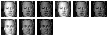

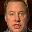

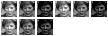

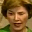

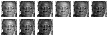

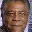

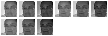

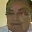

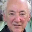

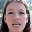

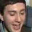

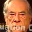

In [5]:
-- generate smaller validation set with previous and subsequent frames
valinputs = torch.FloatTensor(opt.valSize, opt.num_frames * opt.inchan, 16, 16)
valtruths = torch.FloatTensor(opt.valSize, opt.inchan, 32, 32)

for vi = 1, opt.valSize do
    local rand_id = torch.random(2, valimgs:size(1) - 1)
    while not (valvidnames[rand_id] == valvidnames[rand_id - 1] and valvidnames[rand_id] == valvidnames[rand_id + 1]) do
        rand_id = torch.random(2, valimgs:size(1) - 1)
    end
    valinputs[vi] = torch.cat(valimgs[rand_id - 1], valimgs[rand_id], 1):cat(valimgs[rand_id + 1], 1)
    valtruths[vi] = vallabels[rand_id]
end

if not opt.gpu then
    for vi = 1, 4 do
        itorch.image(valinputs[vi])
        itorch.image(valtruths[vi])
    end
end


-- test construct batch
inputs = torch.FloatTensor(opt.batchsize, opt.inchan * opt.num_frames, 16, 16)
labels = torch.FloatTensor(opt.batchsize, opt.outchan, 32, 32)

for bi = 1, opt.batchsize do
    local rand_id = torch.random(2, input_imgs:size(1) - 1)
    while not(invidnames[rand_id] == invidnames[rand_id - 1] and invidnames[rand_id] == invidnames[rand_id + 1]) do
        rand_id = torch.random(2, input_imgs:size(1) - 1)
    end  
    inputs[bi] = torch.cat(input_imgs[rand_id - 1], input_imgs[rand_id], 1):cat(input_imgs[rand_id + 1], 1)
    labels[bi] = label_imgs[rand_id]
end
if not opt.gpu then
    for bi = 1, 4 do
        itorch.image(inputs[{bi, {4,6}, {}, {}}])
--         itorch.image(inputs[bi])
        itorch.image(labels[bi])
    end
end

gen = torch.load('srez_model_video_16_to_32.t7')
if opt.gpu then
    input_imgs = input_imgs:cuda()
    label_imgs = label_imgs:cuda()
    valimgs = valimgs:cuda()
    vallabels = vallabels:cuda()
    valinputs = valinputs:cuda()
    valtruths = valtruths:cuda()
    gen = gen:cuda()
    disc = disc:cuda()
end

In [ ]:
require 'optim'

criterionD = nn.BCECriterion()
if opt.gpu then
    criterionD:cuda()
end
local optimStateD = {learningRate = 0.001}

real_label = 1
fake_label = 0

inputs = torch.FloatTensor(opt.batchsize, opt.inchan * opt.num_frames, 16, 16)
labels = torch.FloatTensor(opt.batchsize, opt.outchan, 32, 32)
disclabels = torch.FloatTensor(opt.batchsize)
valdisclabels = torch.FloatTensor(opt.valSize)
if opt.gpu then
    inputs = inputs:cuda()
    labels = labels:cuda()
    disclabels = disclabels:cuda()
    valdisclabels = valdisclabels:cuda()
end
outputs = nil

epoch_tm = torch.Timer()
total_tm = torch.Timer()

-- training just the discriminator on pre-trained L1 loss generator
for epoch = 1, opt.num_epoch do
    
    -- construct batch
    for bi = 1, opt.batchsize do
        local rand_id = torch.random(2, input_imgs:size(1) - 1)
        while not(invidnames[rand_id] == invidnames[rand_id - 1] and invidnames[rand_id] == invidnames[rand_id + 1]) do
            rand_id = torch.random(2, input_imgs:size(1) - 1)
        end  
        inputs[bi] = torch.cat(input_imgs[rand_id - 1], input_imgs[rand_id], 1):cat(input_imgs[rand_id + 1], 1)
        labels[bi] = label_imgs[rand_id]
    end
    
    paramsD, gradParamsD = disc:getParameters()
    
    -- evaluation, forwards/backward pass for discriminator
    fDx = function(paramsD)
        gradParamsD:zero()
        
        disclabels:fill(real_label)
        local output = disc:forward(labels)
        local errD_real = criterionD:forward(output, disclabels)
        local df_do = criterionD:backward(output, disclabels)
        disc:backward(labels, df_do)
        
        disclabels:fill(fake_label)
        outputs = gen:forward(inputs)
        local output = disc:forward(outputs)
        local errD_fake = criterionD:forward(output, disclabels)
        local df_do = criterionD:backward(output, disclabels)
        disc:backward(outputs, df_do)

        errD = errD_real + errD_fake
        
        return errD, gradParamsD
    end
    
    -- train
    optim.adam(fDx, paramsD, optimStateD)
    
    -- validate
    if epoch % 200 == 0 then
        outputs = gen:forward(valinputs)
        if not opt.gpu then
            for vi = 1, 4 do
--                 itorch.image(valinputs[vi])
--                 itorch.image(outputs[vi])
                itorch.image(image.scale(valinputs[{vi, {4,6}, {}, {}}], 64, 64, 'simple'))
                itorch.image(image.scale(outputs[vi], 64, 64, 'simple'))
            end
        end
        valdisclabels:fill(fake_label)
        valerr = criterionD:forward(disc:forward(outputs), valdisclabels)
        print(('\nvalidation error at epoch = %d is %.4f \t Time Taken: %.3f'):format(epoch, valerr, epoch_tm:time().real))
        
        epoch_tm:reset()
    end
    gen:clearState()
end
print(('\n total time taken: %.3f'):format(total_tm:time().real))
disc = disc:float()
torch.save('srez_model_disc_local.t7', disc)

In [ ]:
require 'optim'

criterionG = nn.AbsCriterion()
criterionD = nn.BCECriterion()
if opt.gpu then
    criterionG:cuda()
    criterionD:cuda()
end
local optimStateD = {learningRate = 0.001}
local optimStateG = {learningRate = 0.001}

real_label = 1
fake_label = 0

inputs = torch.FloatTensor(opt.batchsize, opt.inchan * opt.num_frames, 16, 16)
labels = torch.FloatTensor(opt.batchsize, opt.outchan, 32, 32)
disclabels = torch.FloatTensor(opt.batchsize)
valdisclabels = torch.FloatTensor(opt.valSize)
if opt.gpu then
    inputs = inputs:cuda()
    labels = labels:cuda()
    disclabels = disclabels:cuda()
    valdisclabels = valdisclabels:cuda()
end
outputs = nil

epoch_tm = torch.Timer()
total_tm = torch.Timer()
for epoch = 1, opt.num_epoch do
    
    -- construct batch
    for bi = 1, opt.batchsize do
        local rand_id = torch.random(2, input_imgs:size(1) - 1)
        while not(invidnames[rand_id] == invidnames[rand_id - 1] and invidnames[rand_id] == invidnames[rand_id + 1]) do
            rand_id = torch.random(2, input_imgs:size(1) - 1)
        end  
        inputs[bi] = torch.cat(input_imgs[rand_id - 1], input_imgs[rand_id], 1):cat(input_imgs[rand_id + 1], 1)
        labels[bi] = label_imgs[rand_id]
    end
    
    paramsG, gradParamsG = gen:getParameters()
    paramsD, gradParamsD = disc:getParameters()
    
    -- evaluation, forwards/backward pass for discriminator
    fDx = function(paramsD)
        gradParamsD:zero()
        
        disclabels:fill(real_label)
        local output = disc:forward(labels)
        local errD_real = criterionD:forward(output, disclabels)
        local df_do = criterionD:backward(output, disclabels)
        disc:backward(labels, df_do)
        
        disclabels:fill(fake_label)
        outputs = gen:forward(inputs)
        local output = disc:forward(outputs)
        local errD_fake = criterionD:forward(output, disclabels)
        local df_do = criterionD:backward(output, disclabels)
        disc:backward(outputs, df_do)

        errD = errD_real + errD_fake
        
        return errD, gradParamsD
    end
    
    -- evaluation, forwards/backward pass for generator
    fGx = function(paramsG)
        gradParamsG:zero()

        disclabels:fill(real_label)
        
        errG = criterionG:forward(outputs, labels) * opt.lambda
        errG = errG + criterionD:forward(disclabels, disc.output) * (1 - opt.lambda)
        
        df_doG = criterionG:backward(outputs, labels)
        df_doD = criterionD:backward(disc.output, disclabels)
        
        df_dg = disc:updateGradInput(outputs, df_doD)
        
        gen:backward(inputs, df_dg * (1 - opt.lambda) + df_doG * opt.lambda)
        return errG, gradParamsG
    end
    
    
    -- train
    optim.adam(fDx, paramsD, optimStateD)
    optim.adam(fGx, paramsG, optimStateG)
    
    -- validate
    if epoch % 200 == 0 then
        outputs = gen:forward(valinputs)
        if not opt.gpu then
            for vi = 1, 4 do
--                 itorch.image(valinputs[vi])
--                 itorch.image(outputs[vi])
                itorch.image(image.scale(valinputs[{vi, {4,6}, {}, {}}], 64, 64, 'simple'))
                itorch.image(image.scale(outputs[vi], 64, 64, 'simple'))
            end
        end
        valdisclabels:fill(real_label)
        valerr = criterionG:forward(outputs, valtruths) * opt.lambda
        valerr = valerr + criterionD:forward(disc:forward(outputs), valdisclabels) * (1 - opt.lambda)
        print(('\nvalidation error at epoch = %d is %.4f \t Time Taken: %.3f'):format(epoch, valerr, epoch_tm:time().real))
        
        epoch_tm:reset()
    end
    gen:clearState()
end
print(('\n total time taken: %.3f'):format(total_tm:time().real))
gen = gen:float()
disc = disc:float()
torch.save('srez_model_gen_local.t7', gen)
torch.save('srez_model_disc_local.t7', disc)